**杰克租车问题**

杰克管理一个全国性汽车出租公司的两个地点
每天一些顾客到这两个地点租车
如果有车可租，杰克就将车租出并从公司得到10美元的回扣。
如果这个地点没车，杰克就失去了这笔生意。还回的车第二天就可以出租。
为了使需要车的地点有车可租，每天晚上，杰克可以在两个地点间移动车辆，移动每辆车的费用是2美元。

我们假设每个地点的车的需求量和归还量都是泊松分布变量，即$\frac{\lambda ^n}{n!}e^{-\lambda}$,
假设租车$\lambda$的期望值是3和4，还车$\sigma$的期望值是3和2。

为了简化问题，我们假设每个地点的车不多于20辆(多于的车被还回公司，在此问题中消失了)并且一晚上最多移动5辆车。
折扣率为0.9，并描述为一个有限MDP问题，时刻按天计算，状态是每天结束时两个地点的车辆数，动作是晚上在两个地点间移动的车辆数。


**导入包及问题参数**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson

%matplotlib inline

# 每个位置的最大汽车数量
MAX_CARS = 20
# 夜间行驶的最大车辆数
MAX_MOVE_OF_CARS = 5
# 对第一个位置的租赁请求的期望
RENTAL_REQUEST_FIRST_LOC = 3
# 对第二地点的租赁请求的期望
RENTAL_REQUEST_SECOND_LOC = 4
# 对第一个位置返回的汽车数量的期望
RETURNS_FIRST_LOC = 3
# 期望返回的汽车数量排在第二位
RETURNS_SECOND_LOC = 2
# 折扣率
DISCOUNT = 0.9
# 由汽车赚取的美元
RENTAL_CREDIT = 10
# 移动汽车的成本
MOVE_CAR_COST = 2
# 所有可能的操作
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
# 泊松分布的上界
# 如果n大于这个值，那么得到n的概率被截断为0
POISSON_UPPER_BOUND = 11

**泊松分布的概率**

@lam:这个函数的lambda值应该小于10

In [6]:
poisson_cache = dict()
def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

**期望的计算**

In [7]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [在第一个位置的汽车, 在第二个位置的汽车]
    @action:    如果汽车从第一个位置移动到第二个位置，则为正，
                如果汽车从第二个位置移动到第一个位置，则为负数
    @stateValue: 状态价值矩阵
    @constant_returned_cars:  如果设置为True，模型被简化为白天返回的汽车数量变得不变而不是泊松分布的随机值，
    这将减少计算时间并保持最优策略/值状态矩阵几乎相同
    """
    # 初始化总回报
    returns = 0.0
    # 减去车辆运输费用
    returns -= MOVE_CAR_COST * abs(action)
    # 移动后的车辆数
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # 检查所有可能的租赁请求
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # 这两个位置同时发生特定租赁请求数的联合概率，
            # 即第一个位置的租赁请求数为 rental_request_first_loc 的概率和
            # 第二个位置的租赁请求数为 rental_request_second_loc 的概率的乘积
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # 有效的租赁请求应该少于实际的汽车数量
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # 获得租车获得的收益
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # 模型被简化为白天返回的汽车数量变得不变而不是泊松分布的随机值
                # 取回的车，明天可以用来出租
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                # 返回的汽车数量是随机的，服从泊松分布，我们需要对所有可能的返回汽车数量进行求和
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(returned_cars_first_loc, RETURNS_FIRST_LOC) * \
                            poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

**主函数，包含策略迭代**

max value change 196.62783361783852
max value change 134.98823859766583
max value change 91.41415360228919
max value change 67.17097732555729
max value change 51.29055484635097
max value change 38.49091000659837
max value change 29.406139835126424
max value change 25.7210573245398
max value change 22.381602293031023
max value change 19.40385808254939
max value change 16.77577350573091
max value change 14.47251552455765
max value change 12.464101852186843
max value change 10.719367983418692
max value change 9.20806226246873
max value change 7.9019189666795455
max value change 6.775146571130392
max value change 5.8045764710083745
max value change 4.969618520007145
max value change 4.252112693842776
max value change 3.6361309524054946
max value change 3.107761240497666
max value change 2.654891834022692
max value change 2.26700589940549
max value change 1.9349911763441128
max value change 1.650966802154585
max value change 1.4081276418079938
max value change 1.2006055672075036
max value c

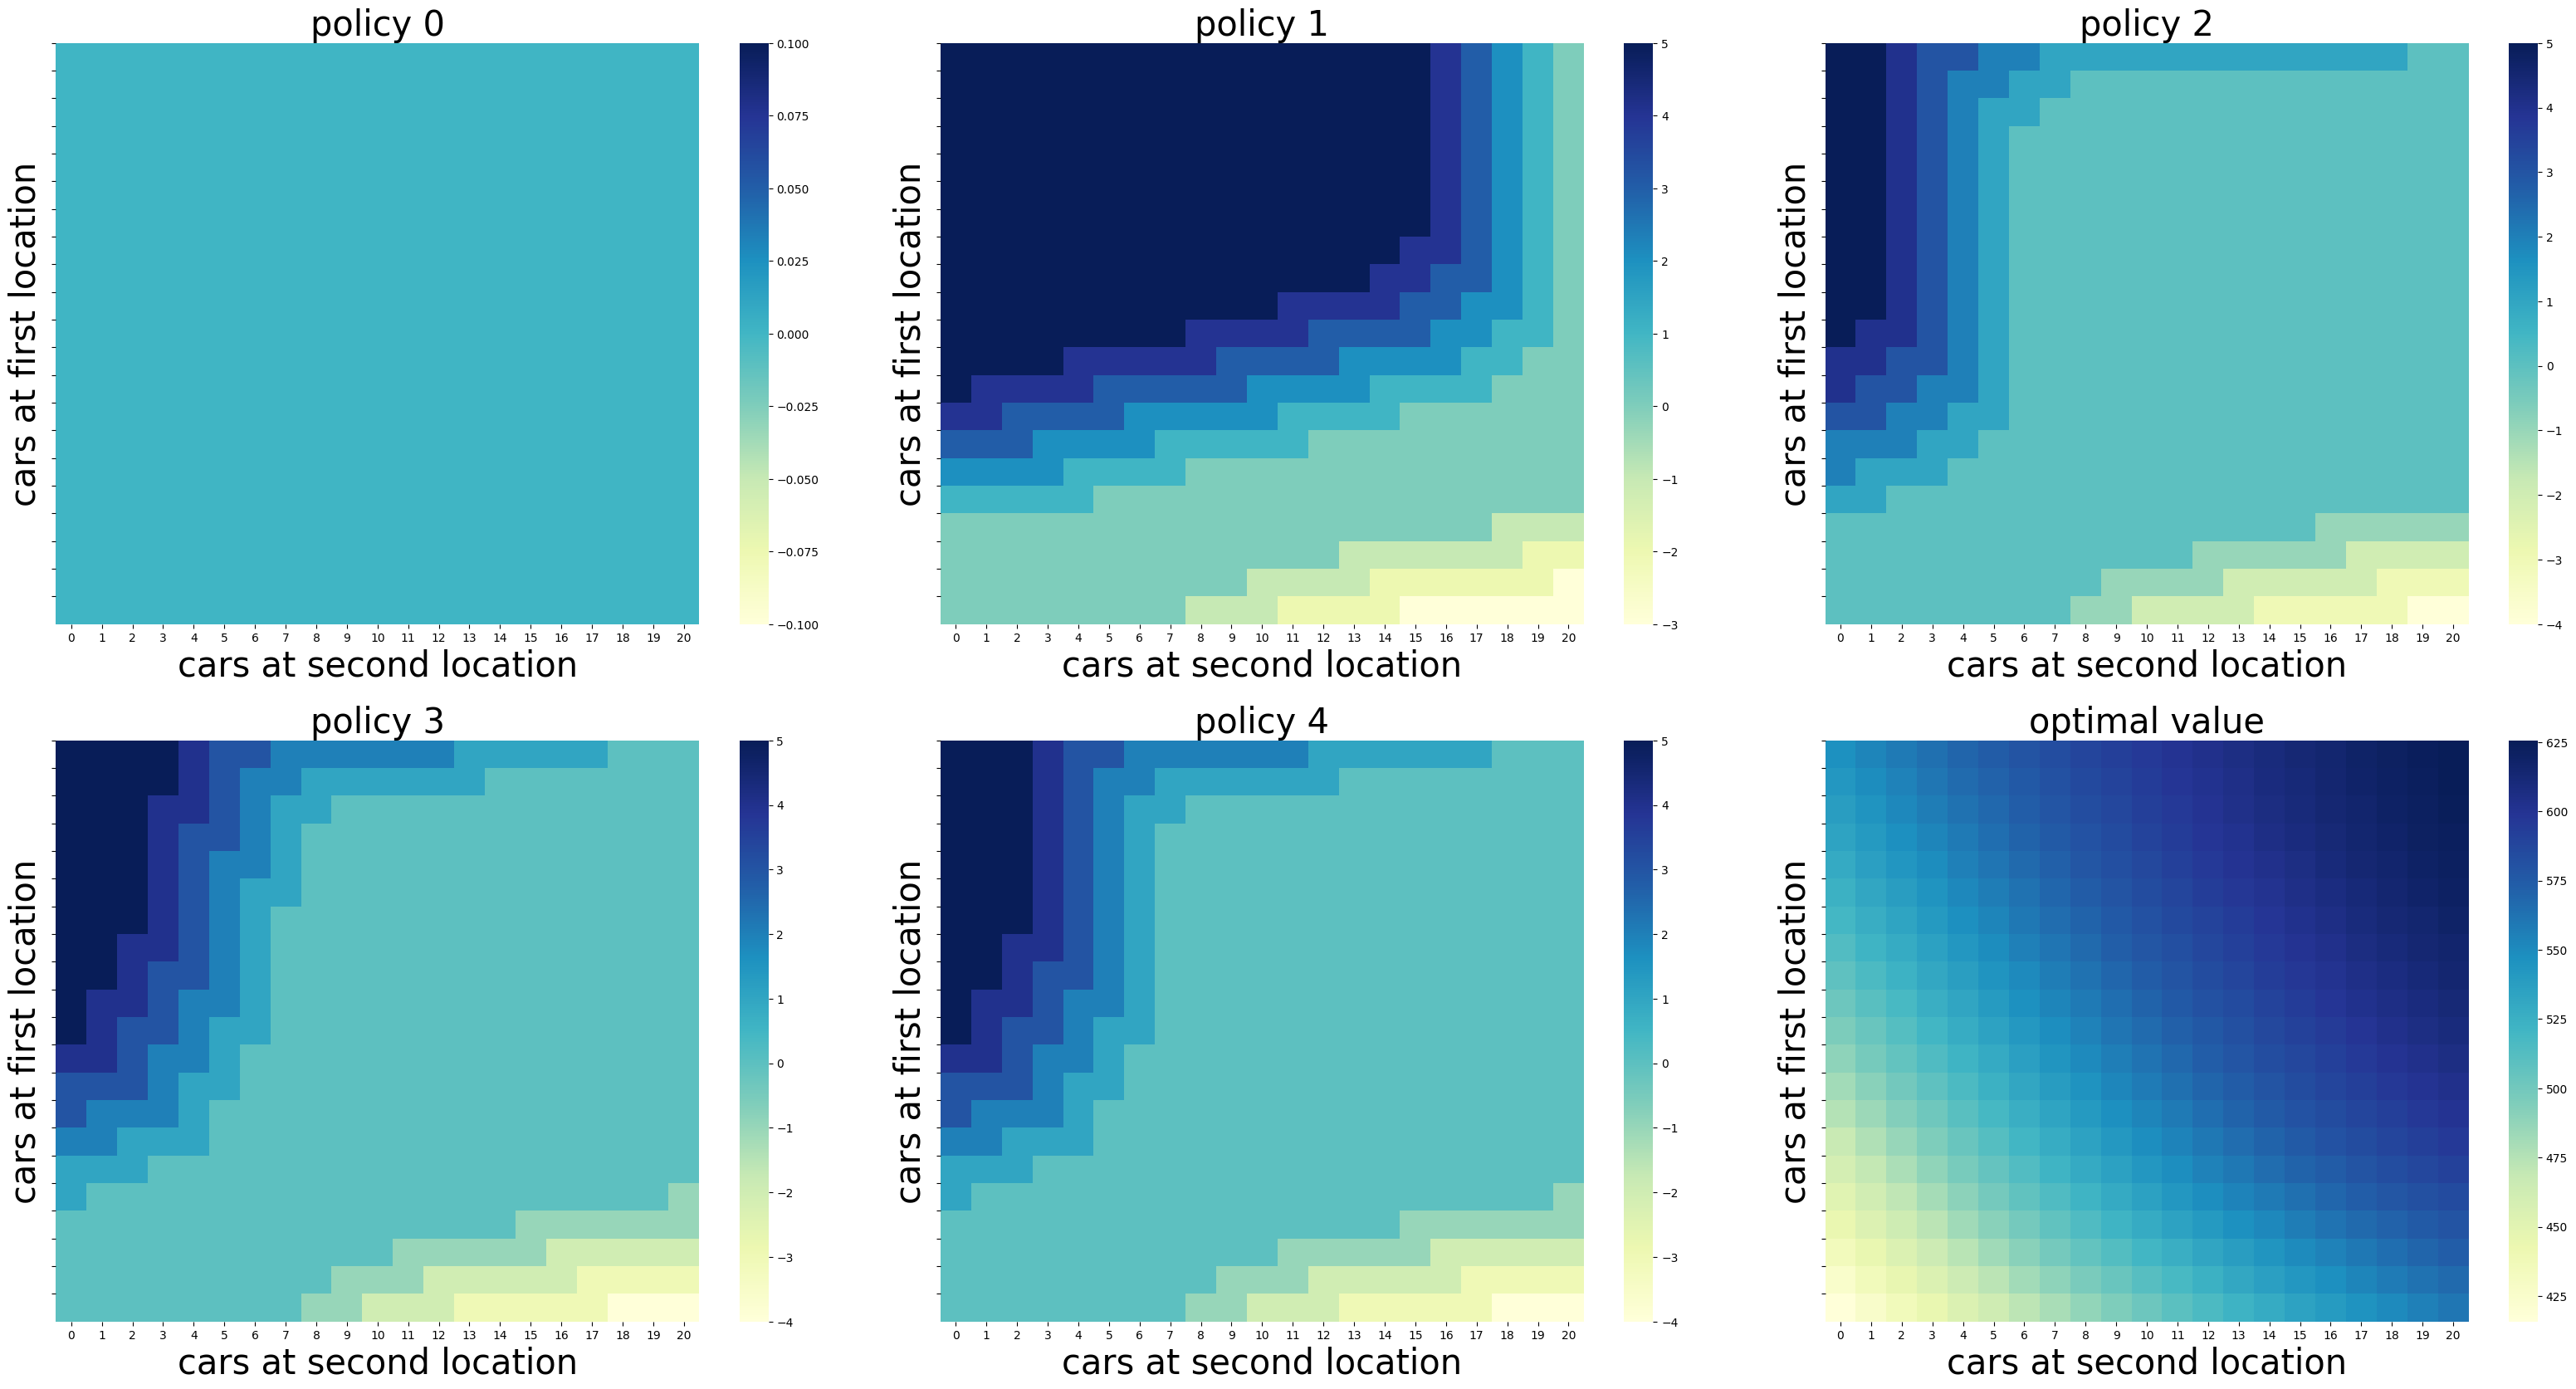

In [8]:
if __name__ == '__main__':
    constant_returned_cars=True
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=int)  # 修改此行

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

        # 策略评价 (in-place)
        while True:
            old_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                    value[i, j] = new_state_value
            max_value_change = abs(old_value - value).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # 策略改进
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print('policy stable {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    plt.show()